In [1]:
import pysam
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib_venn import *
import pysam
from pyBioInfo.IO.File import BedFile
import venn

# Benchmark of MHC SNPs (GIAB, 1KG, NanoStrand-seq, Bulk PB-CCS)

In [2]:
def load_mhc_vcf(path):
    mhc = ["chr6", 28510120, 33480577]

    snvs = dict()
    with pysam.VariantFile(path) as f:
        name = list(f.header.samples)[0]
        for record in f.fetch(mhc[0], mhc[1], mhc[2]):
            gt = record.samples[name]["GT"]
            ps = ""
            try:
                ps = record.samples[name]["PS"]
            except KeyError:
                pass
            a1, a2 = record.alleles[gt[0]], record.alleles[gt[1]]
            if len(a1) > 1 or len(a2) > 1:
                continue
            snvs[record.start] = [record.ref, a1, a2, ps]
    return snvs

snvs1 = load_mhc_vcf("../../public/GRCh38-HG001-Variant-Calls/results/HG001_GRCh38_1_22_v4.2.1_benchmark_hifiasm_v11_phasetransfer.revised_mhc.vcf.gz")
snvs2 = load_mhc_vcf("../../public/OneKG/NA12878.1kg.GRCh38.reheader.patmat.vcf.gz")
snvs3 = load_mhc_vcf("../../4_NanoStrandSeq_Phasing/results/HG001_Cell_350/round2/snvs.vcf.gz")
snvs4 = load_mhc_vcf("../../3_NanoStrandSeq_PseudoBulk/results/snvs/concated/nanocaller/PacBio.full.vcf.gz")
snvs5 = load_mhc_vcf("../../3_NanoStrandSeq_PseudoBulk/results/snvs/concated/nanocaller/Ultralong.full.vcf.gz")

0.8973486830629688


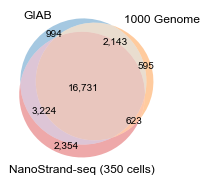

In [4]:
sites1 = set(snvs1.keys())
sites2 = set(snvs2.keys())
sites3 = set(snvs3.keys())

p = len((sites3 & sites1) | (sites3 & sites2)) / len(sites3)
print(p)

plt.figure(figsize=(4, 3))
ret = venn3([sites1, sites2, sites3], 
            set_labels=["GIAB", "1000 Genome", "NanoStrand-seq (350 cells)"], 
            set_colors=["C0", "C1", "C3"])
for obj in ret.subset_labels:
    obj.set_text(format(int(obj.get_text()), ","))
# venn3_circles([sites1, sites2, sites3], lw=0.5)
plt.savefig("figures/mhc_benchmark.calling.pdf", dpi=300)

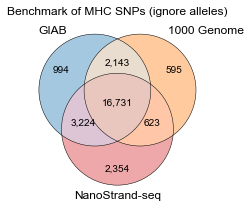

In [5]:
plt.figure(figsize=(4, 3))
plt.title("Benchmark of MHC SNPs (ignore alleles)")
ret = venn3([1, 1, 1, 1, 1, 1, 1], 
            set_labels=["GIAB", "1000 Genome", "NanoStrand-seq"], 
            set_colors=["C0", "C1", "C3"])
ret.subset_labels[0].set_text(format(len(sites1 - sites2 - sites3), ","))
ret.subset_labels[1].set_text(format(len(sites2 - sites1 - sites3), ","))
ret.subset_labels[2].set_text(format(len(sites1 & sites2 - sites3), ","))
ret.subset_labels[3].set_text(format(len(sites3 - sites1 - sites2), ","))
ret.subset_labels[4].set_text(format(len(sites1 & sites3 - sites2), ","))
ret.subset_labels[5].set_text(format(len(sites2 & sites3 - sites1), ","))
ret.subset_labels[6].set_text(format(len(sites1 & sites2 & sites3), ","))
venn3_circles([1, 1, 1, 1, 1, 1, 1], lw=0.5)

plt.tight_layout()
plt.savefig("figures/mhc_benchmark.calling.equal_area.pdf", dpi=300)

In [6]:
counter = defaultdict(int)
hets = []
for start in sites1 & sites2 & sites3:
    ref, a1, a2, ps1 = snvs1[start]
    ref, b1, b2, ps2 = snvs2[start]
    ref, c1, c2, ps3 = snvs3[start]
    alleles = [ref]
    for a in sorted([a1, a2, b1, b2, c1, c2]):
        if a not in alleles:
            alleles.append(a)
    
    i1, i2 = alleles.index(a1), alleles.index(a2)
    if i1 > i2:
        i1, i2 = i2, i1
    gt1 = "%d/%d" % (i1, i2)
    
    i1, i2 = alleles.index(b1), alleles.index(b2)
    if i1 > i2:
        i1, i2 = i2, i1
    gt2 = "%d/%d" % (i1, i2)
    
    i1, i2 = alleles.index(c1), alleles.index(c2)
    if i1 > i2:
        i1, i2 = i2, i1
    gt3 = "%d/%d" % (i1, i2)
    
    counter[(gt1, gt2, gt3)] += 1
    
    if gt1 == "0/1" and gt2 == gt1 and gt3 == gt1:
        hets.append(start)
    
rows = []
for (gt1, gt2, gt3), n in counter.items():
    rows.append([gt1, gt2, gt3, n])
df = pd.DataFrame(rows)
df.columns = ["GIAB", "1KG", "NSS", "Number"]
df = df.sort_values(by="Number", ascending=False)
df.index = np.arange(len(df))
vs = df["Number"].values
# p = sum(vs[:3]) / sum(vs)

p = df[df["GIAB"] == df["NSS"]]["Number"].sum() / sum(vs)
print(p)
p = df[df["1KG"] == df["NSS"]]["Number"].sum() / sum(vs)
print(p)
p = df[(df["GIAB"] == df["NSS"]) | (df["1KG"] == df["NSS"])]["Number"].sum() / sum(vs)
print(p)

df.to_excel("data/genotyping_precision.3sources.xlsx")
df

0.9955173032096108
0.9880461418922958
0.9960552268244576


,GIAB,1KG,NSS,Number
0,0/1,0/1,0/1,11665
1,1/1,1/1,1/1,4857
2,0/1,1/1,0/1,115
3,0/1,0/1,1/1,43
4,1/1,0/1,1/1,17
5,1/2,2/2,0/2,15
6,1/2,2/2,2/2,8
7,1/1,1/1,0/1,5
8,1/2,2/2,1/2,1
9,1/2,0/2,0/2,1


In [7]:
counter = defaultdict(int)
for start in hets:
    ref, a1, a2, ps1 = snvs1[start]
    ref, b1, b2, ps2 = snvs2[start]
    ref, c1, c2, ps3 = snvs3[start]
    if ps1 != "PATMAT" or ps2 != "PATMAT" or ps3 != "PATMAT":
        continue
        
    alleles = [ref]
    for a in sorted([a1, a2, b1, b2, c1, c2]):
        if a not in alleles:
            alleles.append(a)
    
    i1, i2 = alleles.index(a1), alleles.index(a2)
    gt1 = "%d|%d" % (i1, i2)
    
    i1, i2 = alleles.index(b1), alleles.index(b2)
    gt2 = "%d|%d" % (i1, i2)
    
    i1, i2 = alleles.index(c1), alleles.index(c2)
    i1, i2 = i2, i1
    gt3 = "%d|%d" % (i1, i2)
    
    counter[(gt1, gt2, gt3)] += 1

rows = []
for (gt1, gt2, gt3), n in counter.items():
    rows.append([gt1, gt2, gt3, n])
df = pd.DataFrame(rows)
df.columns = ["GIAB", "1KG", "NSS", "Number"]
df.sort_values(by="Number", ascending=False)
print(sum(df["Number"]))
df

11662


,GIAB,1KG,NSS,Number
0,0|1,0|1,0|1,6082
1,1|0,1|0,1|0,5455
2,0|1,1|0,0|1,38
3,1|0,0|1,1|0,87


0.9730507587650444


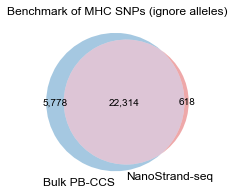

In [8]:
# NanoStrand-seq vs. PB-CCS

sites4 = set(snvs4.keys())
p = len(sites3 & sites4) / len(sites3)
print(p)

plt.figure(figsize=(4, 3))
plt.title("Benchmark of MHC SNPs (ignore alleles)")
ret = venn2([sites4, sites3], set_labels=["Bulk PB-CCS", "NanoStrand-seq"], set_colors=["C0", "C3"])
for obj in ret.subset_labels:
    obj.set_text(format(int(obj.get_text()), ","))
plt.savefig("figures/mhc_benchmark.calling.pbccs.pdf", dpi=300)

In [9]:
data = [
    ["HOM", "HOM", 0],
    ["HOM", "HOM.2", 0],
    ["HOM", "HET", 0],
    ["HET", "HOM", 0],
    ["HET", "HET", 0],
    ["HET", "HET.2", 0],
]
for start in sites3 & sites4:
    ref, a1, a2, ps1 = snvs4[start]
    ref, b1, b2, ps2 = snvs3[start]
    if a1 == a2:
        if b1 == b2:
            if a1 == b1:
                data[0][2] += 1
            else:
                data[1][2] += 1
        else:
            data[2][2] += 1
    else:
        if b1 == b2:
            data[3][2] += 1
        elif (a1 == b1 and a2 == b2) or (a1 == b2 and a2 == b1):
            data[4][2] += 1
        else:
            data[5][2] += 1
    
df = pd.DataFrame(data)
df.columns = ["PB-CCS", "NSS", "Number"]
vs = list(sorted(df["Number"].values))
p = sum(vs[-2:]) / sum(vs)
print(p)
df

0.989961459173613


,PB-CCS,NSS,Number
0,HOM,HOM,5934
1,HOM,HOM.2,5
2,HOM,HET,79
3,HET,HOM,131
4,HET,HET,16156
5,HET,HET.2,9


# Upset plot (GIAB, 1KG, NSS, PB-CCS, ONT-UL)

In [4]:
positions = snvs1.keys() | snvs2.keys() | snvs3.keys() | snvs4.keys() | snvs5.keys()
print(len(positions))

array = []
for p in positions:
    b1 = p in snvs1.keys()
    b2 = p in snvs2.keys()
    b3 = p in snvs4.keys()
    b4 = p in snvs5.keys()
    b5 = p in snvs3.keys()
    array.append(tuple([b1, b2, b3, b4, b5]))
counter = Counter(array)

38585


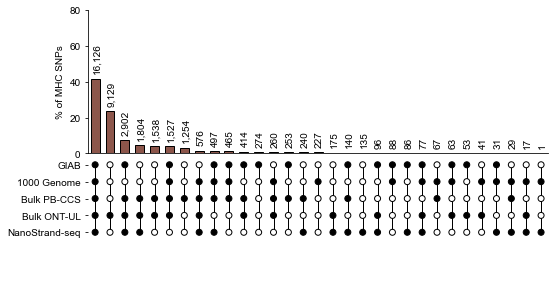

In [18]:
items = list(sorted(Counter(array).items(), key=lambda item: item[1], reverse=True))
total = len(array)

xs = np.arange(len(items))
counts = [item[1] for item in items]
ys = np.array(counts) * 100 / total

fig, axs = plt.subplots(2, 1, figsize=(8, 3.5), sharex=True, 
                        gridspec_kw={"hspace": 0.02, "left": 0.15, "right": 0.95, "bottom": -0.2, "top": 0.95})

# 
ax = axs[0]
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.sca(ax)
plt.bar(xs, ys, edgecolor="black", color="C5", width=0.6)
for x, y, count in zip(xs, ys, counts):
    plt.text(x + 0.1, y + 4, format(count, ","), ha="center", rotation=90)
plt.xlim(min(xs) - 0.5, max(xs) + 0.5)
plt.ylim(0, 80)
plt.ylabel("% of MHC SNPs")

#
ax = axs[1]
for x in ax.spines.values():
    x.set_visible(False)
plt.sca(ax)
xs = []
ys = []
colors = []
for i, item in enumerate(items):
    s = item[0]
    for j, c in enumerate(s):
        xs.append(i)
        ys.append(j)
        if c:
            color = "black"
        else:
            color = "white"
        colors.append(color)
    plt.plot([i, i], [0, 4], lw=1, color="black", zorder=1)
plt.scatter(xs, ys, color=colors, edgecolor="black", zorder=2)
plt.yticks([0, 1, 2, 3, 4], ["GIAB", "1000 Genome", "Bulk PB-CCS", "Bulk ONT-UL", "NanoStrand-seq"])
plt.xticks([])

plt.ylim(8, -0.5)

plt.savefig("figures/benchmark_of_mhc.5_sources.pdf", dpi=300)

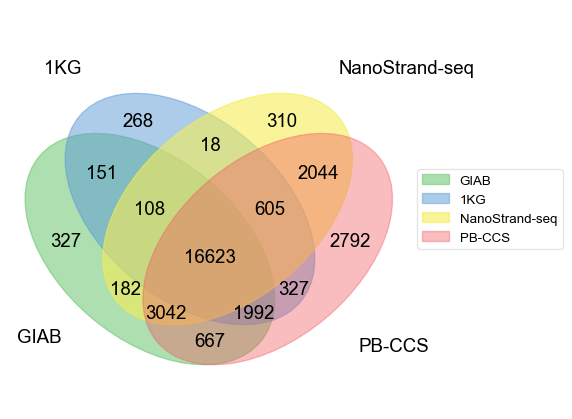

In [12]:
labels = venn.get_labels([snvs1.keys(), snvs2.keys(), snvs3.keys(), snvs4.keys()], fill=['number'])
fig, ax = venn.venn4(labels, names=['GIAB', '1KG', 'NanoStrand-seq', 'PB-CCS'], figsize=(6, 6))
plt.sca(ax)
plt.tight_layout()
plt.show()

# SNP density (track)

In [13]:
mhc = ["chr6", 28510120, 33480577]
region = mhc
region = ["chr6", 28000000, 34000000]

In [14]:
transcripts = dict()
with BedFile("/home/chenzonggui/species/homo_sapiens/GRCh38.p13/gencode.v39.annotation.transcripts.bed.gz") as f:
    for t in f:
        transcripts[t.name] = t

In [15]:
anno = pd.read_csv("/home/chenzonggui/species/homo_sapiens/GRCh38.p13/gencode.v39.annotation.tsv", sep="\t", index_col=0)
anno = anno[(anno["Chrom"] == region[0]) & (anno["Start"] < region[2]) & (anno["End"] > region[1])]
anno = anno[(anno["GeneType"] == "protein_coding") | (anno["GeneType"] == "lncRNA")]
anno = anno[anno["Canonical"]]
len(anno)

275

In [20]:
bin_width = 10000
bin_count = int((region[2] - region[1]) / bin_width)

def get_snv_counts(path):
    counts = np.zeros(bin_count)
    with pysam.VariantFile(path) as f:
        for item in f.fetch(region[0], region[1], region[2]):
            pos = item.start
            counts[int((pos - region[1]) / bin_width)] += 1
    return counts

counts1 = get_snv_counts("../../public/GRCh38-HG001-Variant-Calls/results/benchmark_autosomal_v4.2.1_chrx_v3.3.2.vcf.gz")
counts2 = get_snv_counts("../../public/OneKG/NA12878.1kg.GRCh38.reheader.patmat.vcf.gz")
counts3 = get_snv_counts("../../3_NanoStrandSeq_PseudoBulk/results/snvs/concated/nanocaller/PacBio.full.vcf.gz")
counts4 = get_snv_counts("../../3_NanoStrandSeq_PseudoBulk/results/snvs/concated/nanocaller/Ultralong.full.vcf.gz")
counts5 = get_snv_counts("../../4_NanoStrandSeq_Phasing/results/HG001_Cell_350/round2/snvs.vcf.gz")

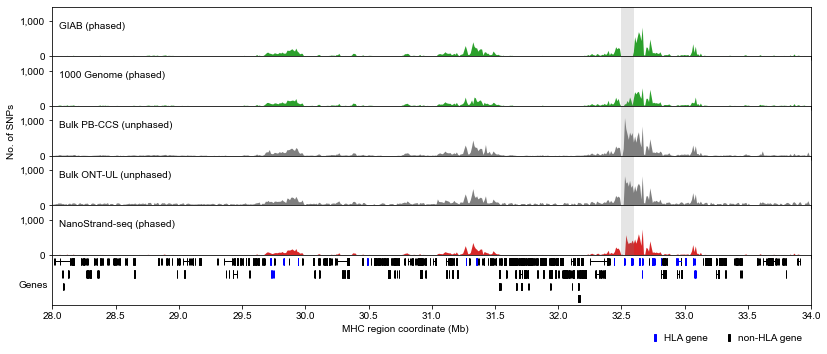

In [25]:
fig, axs = plt.subplots(6, 1, figsize=(11.6, 5), sharex=True, gridspec_kw={"hspace": 0.0})

#
array = [counts1, counts2, counts3, counts4, counts5]
names = ["GIAB (phased)", "1000 Genome (phased)", "Bulk PB-CCS (unphased)", "Bulk ONT-UL (unphased)", "NanoStrand-seq (phased)"]
colors = ["C2", "C2", "C7", "C7", "C3"]
for i, (counts, name, color) in enumerate(zip(array, names, colors)):
    ax = axs[i]
    plt.sca(ax)
    xs = np.arange(region[1], region[2], bin_width) + bin_width / 2
    plt.fill_between(xs, counts, color=color, lw=0)
    plt.axvspan(32500000, 32600000, color="grey", alpha=0.2, lw=0)
    if i == 2:
        plt.ylabel("No. of SNPs")
    plt.ylim(0, 1400)
    plt.yticks([0, 1000], ["0", "1,000"])
    plt.text(28050000, 800, name)

#
ax = axs[-1]
plt.sca(ax)
row_offset = defaultdict(int)
blocks = []
exons = []
for tid, (start, end, name, strand) in zip(anno.index, anno[["Start", "End", "GeneName", "Strand"]].values):
    row_index = 0
    while True:
        if row_offset[row_index] <= start:
            row_offset[row_index] = end
            break
        else:
            row_index += 1
    y = - row_index   
    x1, x2 = start, end
    
    color = "blue" if "HLA" in name else "black"
    
    # gene
    x = (x1 + x2) / 2
    w = x2 - x1
    h = 0.6
    b = y - 0.3
    blocks.append([x, h, b, w, color])
            
    # line
    plt.plot([x1, x2], [y, y], lw=1, color=color)
    
    # exon
    for exon in transcripts[tid].blocks:
        x = (exon[0] + exon[1]) / 2
        w = exon[1] - exon[0]
        h = 0.6
        b = y - h / 2
        exons.append([x, h, b, w, color])
    
if False: # gene body
    plt.bar([item[0] for item in blocks], 
            [item[1] for item in blocks], 
            bottom=[item[2] for item in blocks], 
            width=[item[3] for item in blocks], 
            color=[item[4] for item in blocks])
if True: # exon
    plt.bar([item[0] for item in exons], 
            [item[1] for item in exons], 
            bottom=[item[2] for item in exons], 
            width=[item[3] for item in exons],
            edgecolor=[item[4] for item in exons], 
            lw=1,
            color=[item[4] for item in exons])
plt.xlim(region[1], region[2])
plt.ylim(-max(row_offset.keys()) - 0.5, 0.5)
plt.xlabel("MHC region coordinate (Mb)                   ")
plt.ylabel("Genes", rotation=0, ha="right", va="top")
plt.yticks([])
xs = np.arange(28000000, 34000000 + 1, 500000)
plt.xticks(xs, [str(x / 1000000) for x in xs])
plt.legend(handles=[
    mpatches.Patch(label="HLA gene", color="blue"), 
    mpatches.Patch(label="non-HLA gene", color="black")], 
    ncol=2, handlelength=0.2, loc="upper right", bbox_to_anchor=(1, -0.4), frameon=False)

#
plt.tight_layout()
plt.savefig("figures/gene_model_and_snv_density.mhc.pdf", dpi=300)